#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive


In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content

os.chdir('/content')

--2021-11-24 23:22:30--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.24MB/s    in 1.0s    

2021-11-24 23:22:32 (2.24 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [ ]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [ ]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

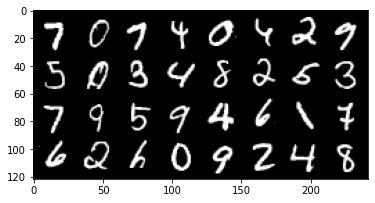

        7         0         7         4


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [ ]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   100] loss: 1.367
[1,   200] loss: 0.491
[1,   300] loss: 0.418
[1,   400] loss: 0.363
[1,   500] loss: 0.369
[1,   600] loss: 0.302
[1,   700] loss: 0.321
[1,   800] loss: 0.269
[1,   900] loss: 0.265
[1,  1000] loss: 0.276
[1,  1100] loss: 0.265
[1,  1200] loss: 0.232
[1,  1300] loss: 0.235
[1,  1400] loss: 0.237
[1,  1500] loss: 0.240
[1,  1600] loss: 0.226
[1,  1700] loss: 0.208
[1,  1800] loss: 0.183


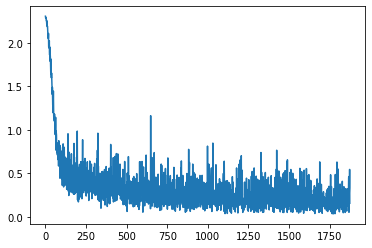

In [ ]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


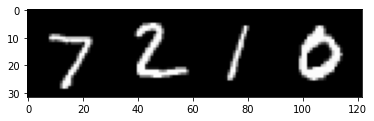

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [ ]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [ ]:
print("Current accuracy: %f" % accuracy(net, data['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current accuracy: 0.947150


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.9621 0.9471 0.894


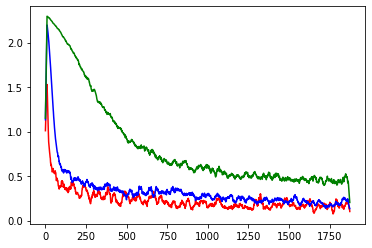

In [ ]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

TODO: Answer here

High momentum (1.0) prevents the model from converging. The loss will gradually swing farther away from the converging point in the loss function. The accuracy decrease drastically over the process.
Low momentum (0.8) will allow the model to converge, although the convergence will happen later than with the default 0.9 value. The accuracy is slightly worse than 0.9 momentum's accuracy.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.5384 0.9503 0.9309


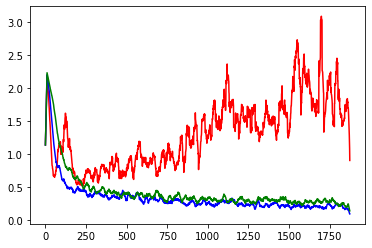

In [ ]:
#TODO: Write your code here for experimenting with different values of momentum.
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.01, momentum=1.0, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, momentum=0.9, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.01, momentum=0.8, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

TODO: Answer here

The current model is overfit to the data. When there is 0 weight decay, the test accuracy is slightly lower than the model with a very small weight decay. This would mean that the weights trained with 0 weight decay are to fit to the training data specifically.

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

TODO: Answer here

High weight decay prevents convergence, and the final accuracy is very low. It seems to make sense, since this would mean that all weights became too regularized, where most of them became close to 0. All these dead weights would mean the model cannot represent the given function at all.

Low weight decay allows the model to get closer to converging. The final accuracy can be better than 0 weight decay. This would make sense that the model can avoid overfitting to get higher performance than with 0 weight decay.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.1135 0.92 0.944 0.9487 0.9486


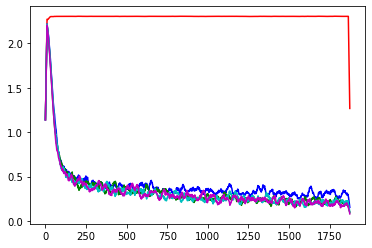

In [ ]:
#TODO: Write your code here for experimenting with different weight decay
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.01, momentum=0.9, decay=1.0, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, momentum=0.9, decay=0.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.01, momentum=0.9, decay=0.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

net_lower = SimpleNet()
losses_lower = train(net_lower, data['train'], lr=.01, momentum=0.9, decay=0.0001, verbose=0)
acc_lower = accuracy(net_lower, data['test'])
plt.plot(smooth(losses_lower,20), 'c-')

net_lowest = SimpleNet()
losses_lowest = train(net_lowest, data['train'], lr=.01, momentum=0.9, decay=0, verbose=0)
acc_lowest = accuracy(net_lowest, data['test'])
plt.plot(smooth(losses_lowest,20), 'm-')

print(acc_high, acc_mid, acc_low, acc_lower, acc_lowest)

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

TODO: Answer here

My final model architecture is:
- Input Layer:    784 x 512
- Hidden layer 1: 512 x 256
- Hidden layer 2: 256 x 512
- Output layer:   512 x 10

My process for creating the model was mostly to ensure the output and input sizes of each layers matched up with each other. I also made sure the number of connections is within bounds. The number of neurons and layers was mostly random however.

####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

TODO: Answer here

I experimented with the following values:

Epochs: 5 works best. Around 7 epochs and up, the returns are very minimal. Around 3 and below, the model has not yet converged yet.

Weight decay: 0.0001 works well. I generally tested values around this range to prevent the previous problems with large weight decay.

I think the model is almost overfitting the data.
The network is more complex than the simplenet. The test accuracy is also still not quite perfect, which could mean that there is a little bit of overfitting.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.978 0.9715 0.9606


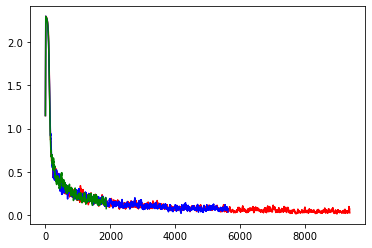

In [ ]:
#TODO: Write your new model and experiments here

import torch.nn as nn
import torch.nn.functional as F

class ExperiNet(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.out(x)
        return x

#TODO: Write your code here for experimenting with different weight decay
net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.01, epochs=5, momentum=0.9, decay=0.0001, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')

net_mid = ExperiNet()
losses_mid = train(net_mid, data['train'], lr=.01, epochs=3, momentum=0.9, decay=0.0001, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')

net_low = ExperiNet()
losses_low = train(net_low, data['train'], lr=.01, epochs=1, momentum=0.9, decay=0.0001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.